# Cut selections for truth leptons

In [1]:
import root_pandas as rp
import pandas as pd
import ROOT
import numpy as np
import matplotlib.pyplot as plt

f = 'mc_with_reco.root'
rf = ROOT.TFile(f)
rf.ls() #list tree names

Welcome to JupyROOT 6.18/04


In [2]:
leptons = rp.read_root(f, key='truth_lepton') #reads dataframe of truth leptons
leptons.columns

Index(['__experiment__', '__run__', '__event__', '__candidate__',
       '__ncandidates__', '__weight__', 'Mbc', 'deltaE', 'isSignal', 'M', 'dM',
       'charge', 'mcPDG', 'genMotherID', 'genMotherP', 'genMotherPDG',
       'genParticleID', 'mcFlightDistance', 'mcFlightTime', 'mcDecayTime',
       'mcDistance', 'mcDRho', 'mcDX', 'mcDY', 'mcDZ', 'mcProdVertexDX',
       'mcProdVertexDY', 'mcProdVertexDZ', 'mcProdVertexX', 'mcProdVertexY',
       'mcProdVertexZ', 'mcRho', 'mcX', 'mcY', 'mcZ', 'mcE', 'mcP', 'mcPT',
       'mcPX', 'mcPY', 'mcPZ', 'mcPhi', 'mcTheta', 'dr', 'eIDBelle',
       'muIDBelle', 'muIDBelleQuality', 'ImpactXY', 'p', 'pErr', 'pt', 'ptErr',
       'px', 'pxErr', 'py', 'pyErr', 'pz', 'pzErr', 'z', 'z_uncertainty',
       'dz'],
      dtype='object')

## Determine best discriminatory variables

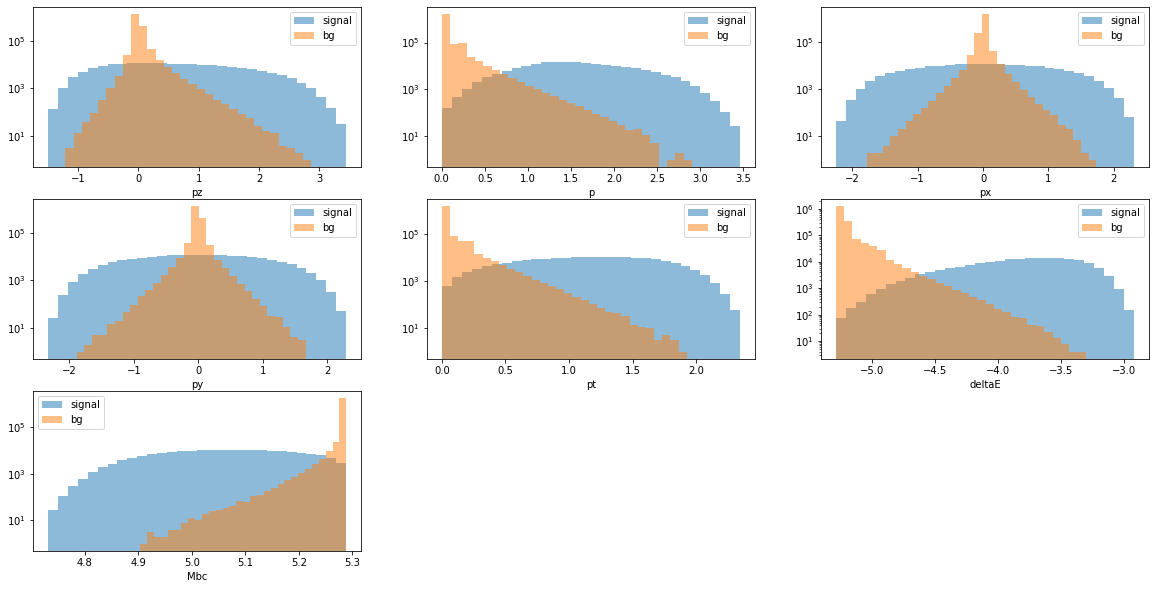

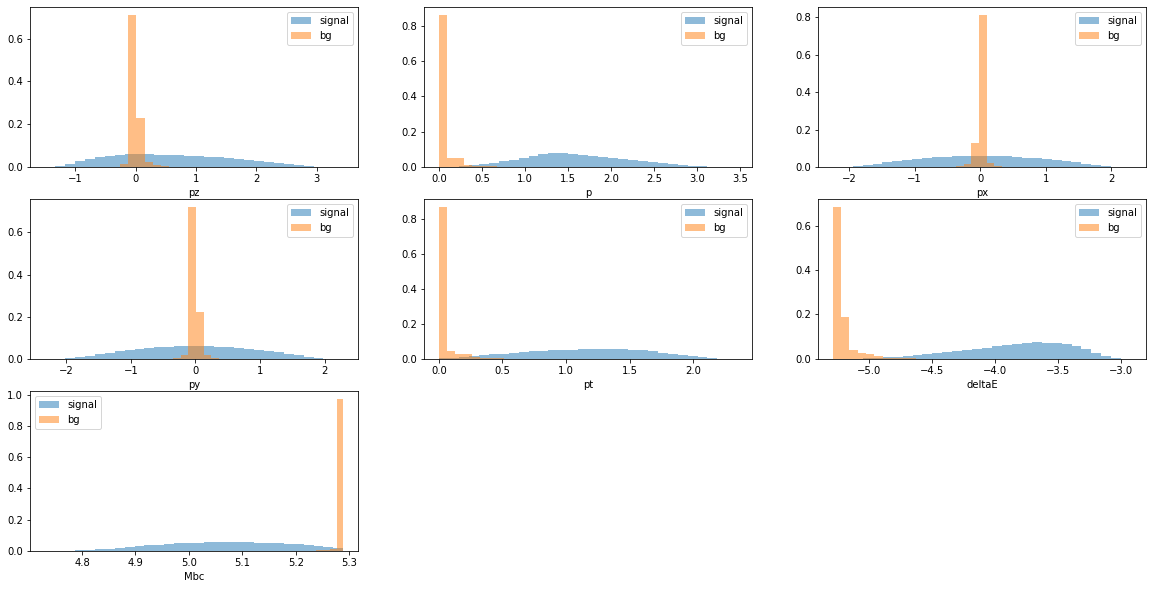

In [168]:
truth_signal = leptons.loc[np.abs(leptons['genMotherPDG'])==511] #selects leptons coming directly from B
truth_bg = leptons.loc[np.abs(leptons['genMotherPDG'])!=511] #selects leptons not coming directly from B
def plot_cuts(signal_df, bg_df, cut_vars = ['pz', 'p', 'px', 'py', 'pt', 'deltaE', 'Mbc']):
    i = 1
    plt.figure(figsize=(20,10))
    plt.tight_layout()
    for var in cut_vars:
        plt.subplot(3,3,i)
        plt.hist(signal_df[var], bins=30, alpha = 0.5, label = 'signal')
        plt.hist(bg_df[var], bins=30, alpha = 0.5, label = 'bg')
        plt.legend()
        plt.yscale("Log")
        #plt.yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
        plt.xlabel('%s'%(var))
        i += 1
    #plt.savefig(output_file)
    plt.show()

def plot_normalized_cuts(signal_df, bg_df, cut_vars = ['pz', 'p', 'px', 'py', 'pt', 'deltaE', 'Mbc']):
    i = 1
    plt.figure(figsize=(20,10))
    plt.tight_layout()
    for var in cut_vars:
        plt.subplot(3,3,i)
        counts_sig, bins_sig = np.histogram(signal_df[var], bins=30)
        counts_bg, bins_bg = np.histogram(bg_df[var], bins=30)
        centers_sig = []
        centers_bg = []
        for j in range(0,len(bins_sig)-1):
            centers_sig.append((bins_sig[j]+bins_sig[j+1])/2)
            centers_bg.append((bins_bg[j]+bins_bg[j+1])/2)
        plt.bar(centers_sig, counts_sig/len(signal_df), width = bins_sig[1]-bins_sig[0], alpha = 0.5, label = 'signal')
        plt.bar(centers_bg, counts_bg/len(bg_df), width = bins_bg[1]-bins_bg[0], alpha = 0.5, label = 'bg')
        plt.legend()
        #plt.yscale("Log")
        #plt.yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
        plt.xlabel('%s'%(var))
        i += 1
    #plt.savefig(output_file)
    plt.show()
plot_cuts(truth_signal, truth_bg)
plot_normalized_cuts(truth_signal, truth_bg)

#### We see that deltaE and Mbc seem to have the largest discriminatory power

## Determining cuts on Mbc and DeltaE Performance

#### 1. Make dataframe for cut performance

In [109]:
def get_performance_for_Mbc_cut(dataframe, cut_val):
    signal = dataframe.loc[(np.abs(dataframe['genMotherPDG'])==511) & (dataframe['Mbc']<cut_val)]
    background = dataframe.loc[(np.abs(dataframe['genMotherPDG'])!=511) & (dataframe['Mbc']<cut_val)]
    truth_signal = dataframe.loc[np.abs(dataframe['genMotherPDG'])==511]
    truth_background = dataframe.loc[np.abs(dataframe['genMotherPDG'])!=511]
    num_signal = len(signal)
    num_background = len(background)
    efficiency = num_signal/len(truth_signal)
    purity = num_signal/(num_signal+num_background)
    return num_signal, num_background, efficiency, purity

def get_performance_for_deltaE_cut(dataframe, cut_val):
    signal = dataframe.loc[(np.abs(dataframe['genMotherPDG'])==511) & (dataframe['deltaE']>cut_val)]
    background = dataframe.loc[(np.abs(dataframe['genMotherPDG'])!=511) & (dataframe['deltaE']>cut_val)]
    truth_signal = dataframe.loc[np.abs(dataframe['genMotherPDG'])==511]
    truth_background = dataframe.loc[np.abs(dataframe['genMotherPDG'])!=511]
    num_signal = len(signal)
    num_background = len(background)
    efficiency = num_signal/len(truth_signal)
    purity = num_signal/(num_signal+num_background)
    return num_signal, num_background, efficiency, purity
    
Mbc_cut_values = np.linspace(5,5.3,61)
deltaE_cut_values = np.linspace(-5.5,-4.5,201)
performance_Mbc = pd.DataFrame()
performance_deltaE = pd.DataFrame()
performance_Mbc['Mbc_cut'] = Mbc_cut_values
performance_deltaE['deltaE_cut'] = deltaE_cut_values
sig_Mbc = []
bg_Mbc = []
eff_Mbc = []
pur_Mbc = []
FOM_Mbc = []
sig_deltaE = []
bg_deltaE = []
eff_deltaE = []
pur_deltaE = []
FOM_deltaE = []
for value in Mbc_cut_values:
    signal, background, efficiency, purity = get_performance_for_Mbc_cut(leptons,value)
    sig_Mbc.append(signal)
    bg_Mbc.append(background)
    eff_Mbc.append(efficiency)
    pur_Mbc.append(purity)
    FOM_Mbc.append(signal/np.sqrt(signal+background))
for value in deltaE_cut_values:
    signal, background, efficiency, purity = get_performance_for_deltaE_cut(leptons,value)
    sig_deltaE.append(signal)
    bg_deltaE.append(background)
    eff_deltaE.append(efficiency)
    pur_deltaE.append(purity)
    FOM_deltaE.append(signal/np.sqrt(signal+background))
performance_Mbc['signal'] = sig_Mbc
performance_Mbc['background']=bg_Mbc
performance_Mbc['efficiency'] = eff_Mbc
performance_Mbc['purity']=pur_Mbc
performance_Mbc['FOM'] = FOM_Mbc
performance_deltaE['signal'] = sig_deltaE
performance_deltaE['background']=bg_deltaE
performance_deltaE['efficiency'] = eff_deltaE
performance_deltaE['purity']=pur_deltaE
performance_deltaE['FOM'] = FOM_deltaE

#### 2. Plot histograms with these cuts

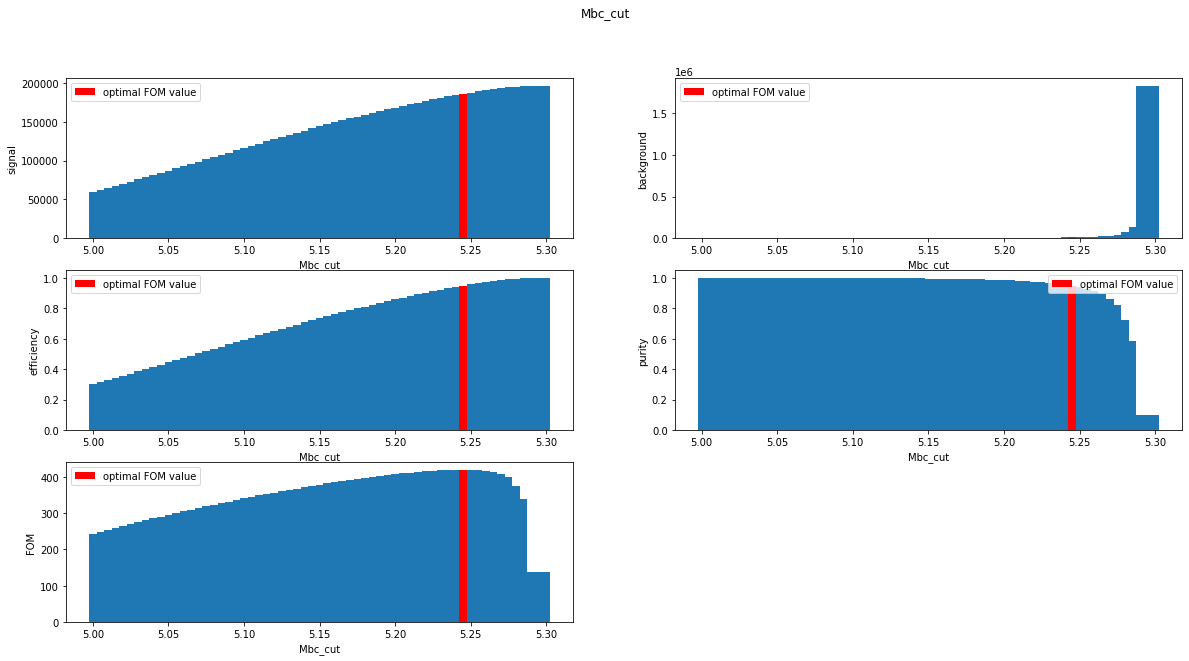

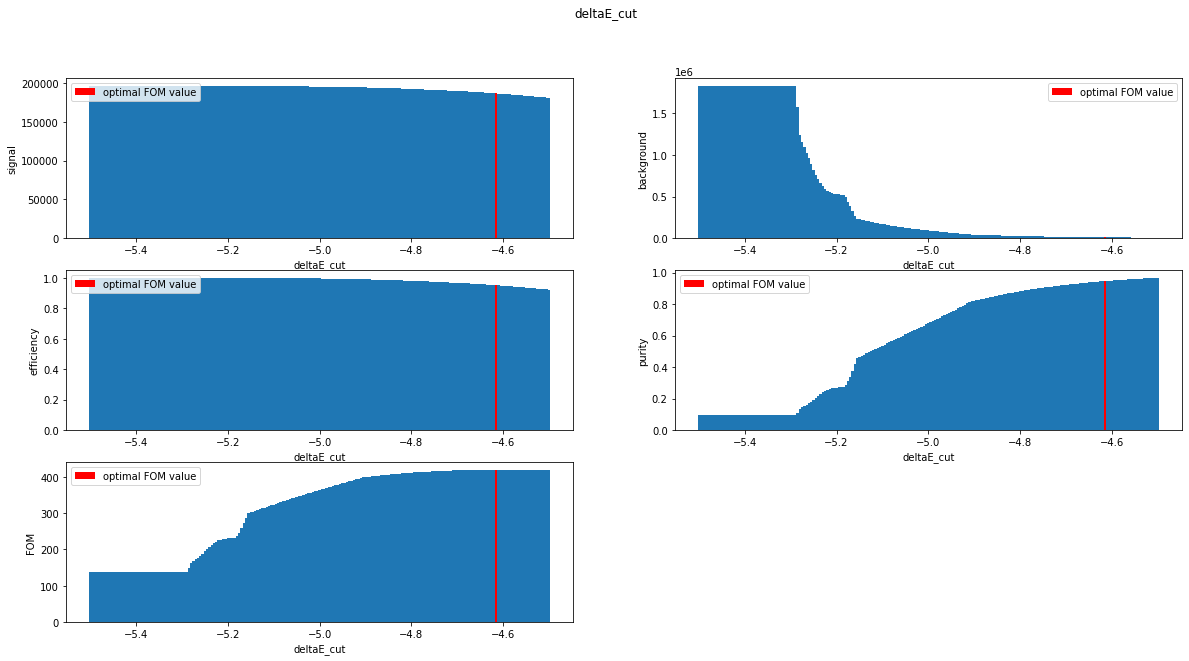

Optimal Mbc cut < 5.245. (Efficiency, purity) at this cut: (0.9482336873432945, 0.9479341790208365)
Optimal deltaE cut > -4.615. (Efficiency, purity) at this cut: (0.9505065536009132, 0.9454667112746739)


In [123]:
def make_plots(performance_df):
    plt.figure(figsize=(20,10))
    plt.tight_layout()
    col = performance_df.columns
    plt.suptitle('%s'%(col[0]))
    critical_index = performance_df.loc[performance_df['FOM']==performance_df['FOM'].max()].index.to_numpy()
    for i in range(1, len(col)):
        plt.subplot(3,2,i)
        plt.bar(performance_df[col[0]], performance_df[col[i]], width = np.abs(performance_df[col[0]].diff()[1]))
        plt.bar(performance_df[col[0]][critical_index], performance_df[col[i]][critical_index], color='red', width = np.abs(performance_df[col[0]].diff()[1]), label = 'optimal FOM value')
        plt.ylabel('%s'%(col[i]))
        plt.xlabel('%s'%(col[0]))
        plt.legend()
    plt.show()
make_plots(performance_Mbc)
make_plots(performance_deltaE)
Mbc_crit_index = performance_Mbc.loc[performance_Mbc['FOM']==performance_Mbc['FOM'].max()].index.to_numpy()
deltaE_crit_index = performance_deltaE.loc[performance_deltaE['FOM']==performance_deltaE['FOM'].max()].index.to_numpy()
print('Optimal Mbc cut < %s. (Efficiency, purity) at this cut: (%s, %s)'%(performance_Mbc['Mbc_cut'][Mbc_crit_index].to_numpy()[0], performance_Mbc['efficiency'][Mbc_crit_index].to_numpy()[0], performance_Mbc['purity'][Mbc_crit_index].to_numpy()[0]))
print('Optimal deltaE cut > %s. (Efficiency, purity) at this cut: (%s, %s)'%(performance_deltaE['deltaE_cut'][deltaE_crit_index].to_numpy()[0], performance_deltaE['efficiency'][deltaE_crit_index].to_numpy()[0], performance_deltaE['purity'][deltaE_crit_index].to_numpy()[0]))
        

#### 3. Plot kinematic distributions at these cuts

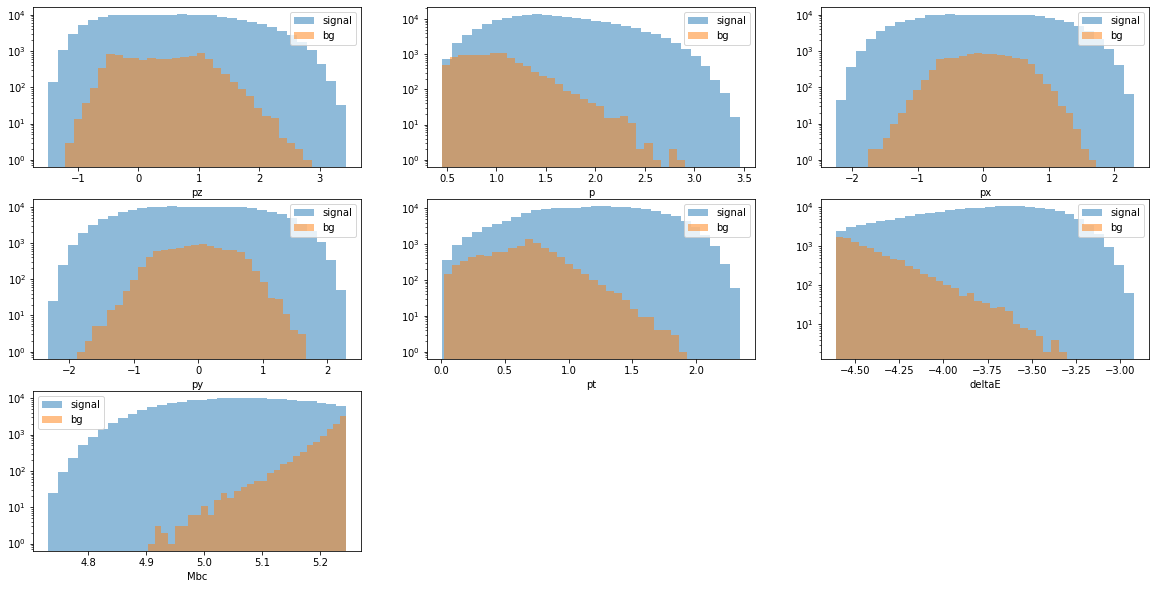

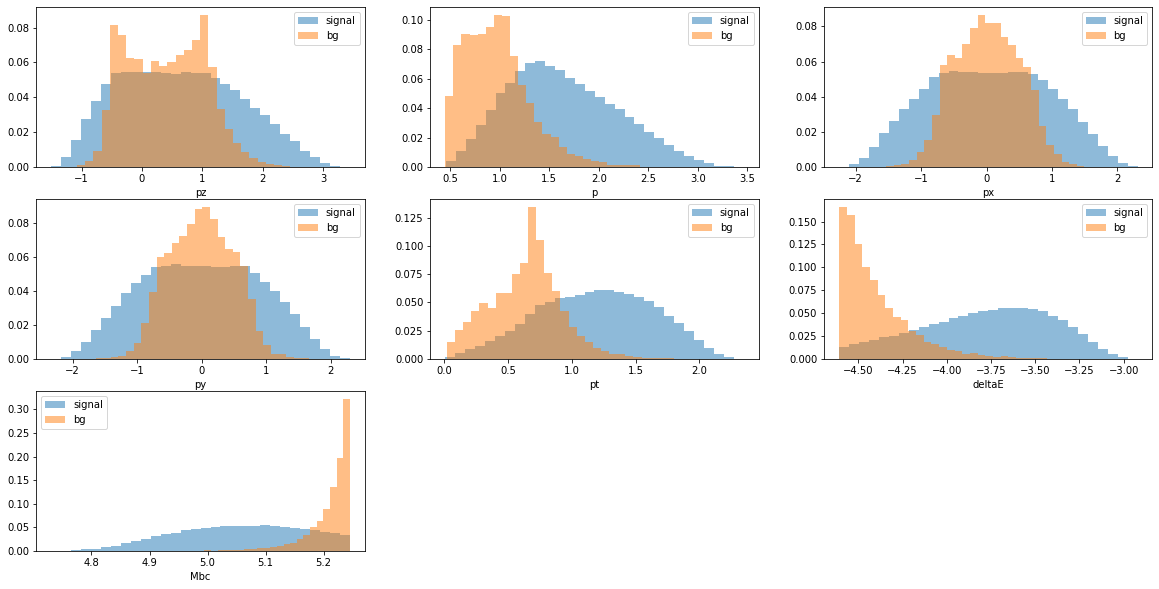

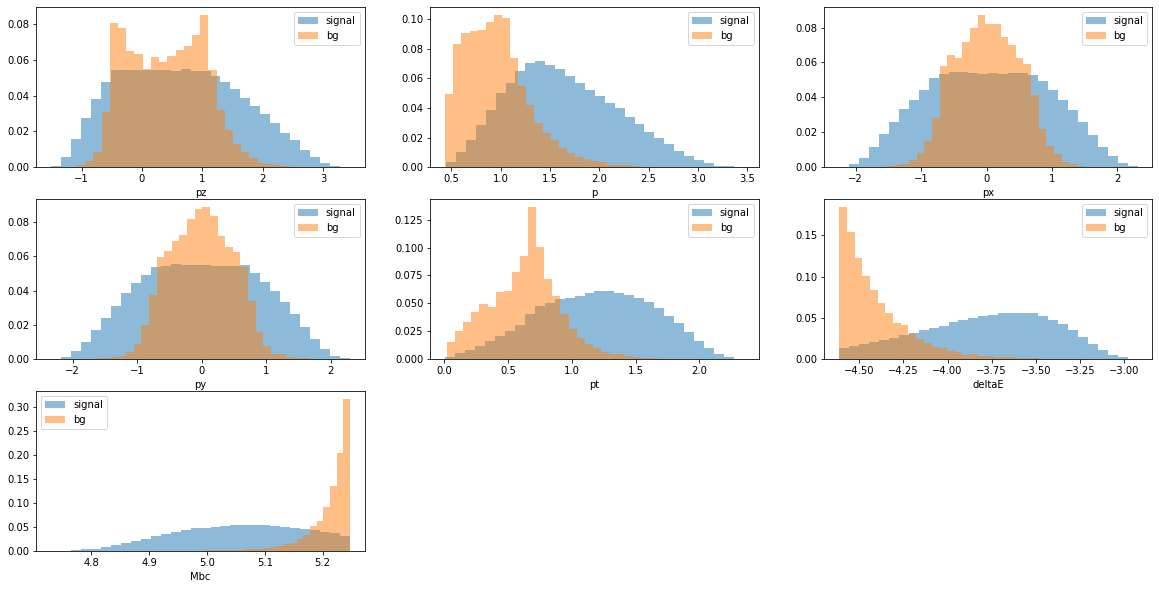

In [169]:
Mbc_cut = performance_Mbc['Mbc_cut'][Mbc_crit_index].to_numpy()[0]
deltaE_cut = performance_deltaE['deltaE_cut'][deltaE_crit_index].to_numpy()[0]
Mbc_optimal_sig = leptons.loc[(np.abs(leptons['genMotherPDG'])==511) & (leptons['Mbc']<Mbc_cut)]
Mbc_optimal_bg = leptons.loc[(np.abs(leptons['genMotherPDG'])!=511) & (leptons['Mbc']<Mbc_cut)]
deltaE_optimal_sig = leptons.loc[(np.abs(leptons['genMotherPDG'])==511) & (leptons['deltaE']>deltaE_cut)]
deltaE_optimal_bg = leptons.loc[(np.abs(leptons['genMotherPDG'])!=511) & (leptons['deltaE']>deltaE_cut)]
both_optimal_sig = leptons.loc[(np.abs(leptons['genMotherPDG'])==511) & (leptons['Mbc']<Mbc_cut) & (leptons['deltaE']>deltaE_cut)]
both_optimal_bg = leptons.loc[(np.abs(leptons['genMotherPDG'])!=511) & (leptons['Mbc']<Mbc_cut) & (leptons['deltaE']>deltaE_cut)]
plot_cuts(Mbc_optimal_sig, Mbc_optimal_bg)
plot_normalized_cuts(Mbc_optimal_sig, Mbc_optimal_bg)
#plot_normalized_cuts(deltaE_optimal_sig, deltaE_optimal_bg)
#plot_cuts(both_optimal_sig, both_optimal_bg)
efficiency = len(both_optimal_sig)/len(truth_signal)
purity = len(both_optimal_sig)/(len(both_optimal_sig)+len(both_optimal_bg))
#print(efficiency, purity)

We found that both cuts perform similarly enough that we don't need to do any joint optimization. We will use Mbc as our selection variable

# Cut selections for MC-Matched data below

In [21]:
e = rp.read_root(f, key='e_lab')
mu = rp.read_root(f, key='mu_lab')
e = e.append(mu)

In [22]:
e = e.sort_values(by='__event__')
e.index = [i for i in range(0,len(e))]

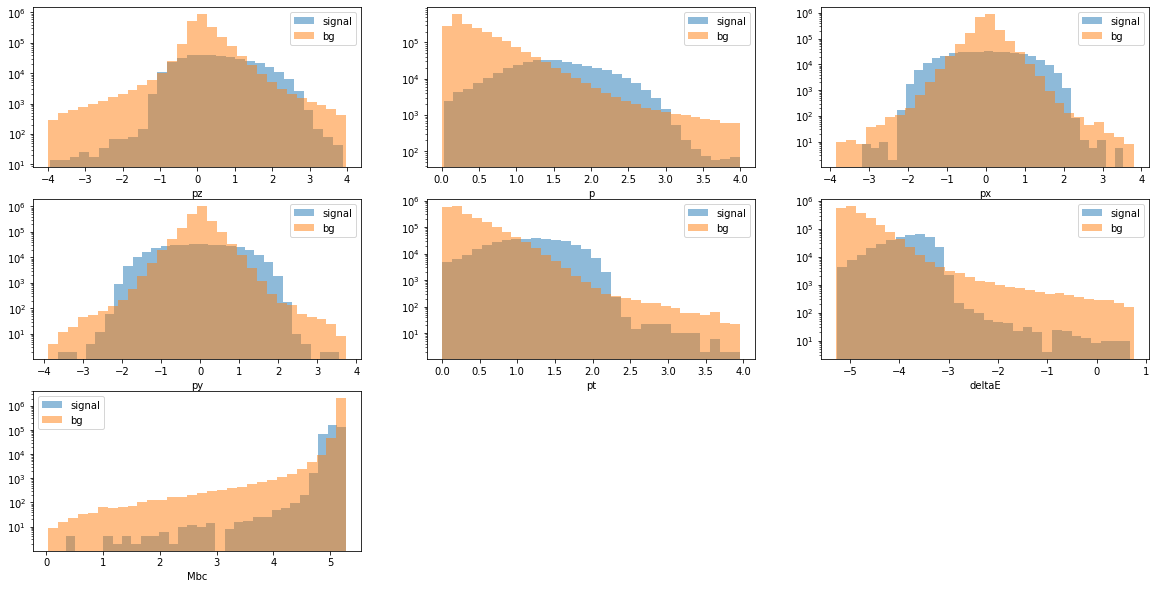

In [52]:
e_precut_sig = e.loc[(np.abs(e['genMotherPDG'])==511) & (np.abs(e['pz'])<4) & (np.abs(e['p'])<4) & (np.abs(e['px'])<4) & (np.abs(e['py'])<4) & (np.abs(e['pt'])<4) & (e['deltaE']<4)]
e_precut_bg = e.loc[(np.abs(e['genMotherPDG'])!=511) & (np.abs(e['pz'])<4) & (np.abs(e['p'])<4) & (np.abs(e['px'])<4) & (np.abs(e['py'])<4) & (np.abs(e['pt'])<4) & (e['deltaE']<4)]
plot_cuts(e_precut_sig, e_precut_bg)

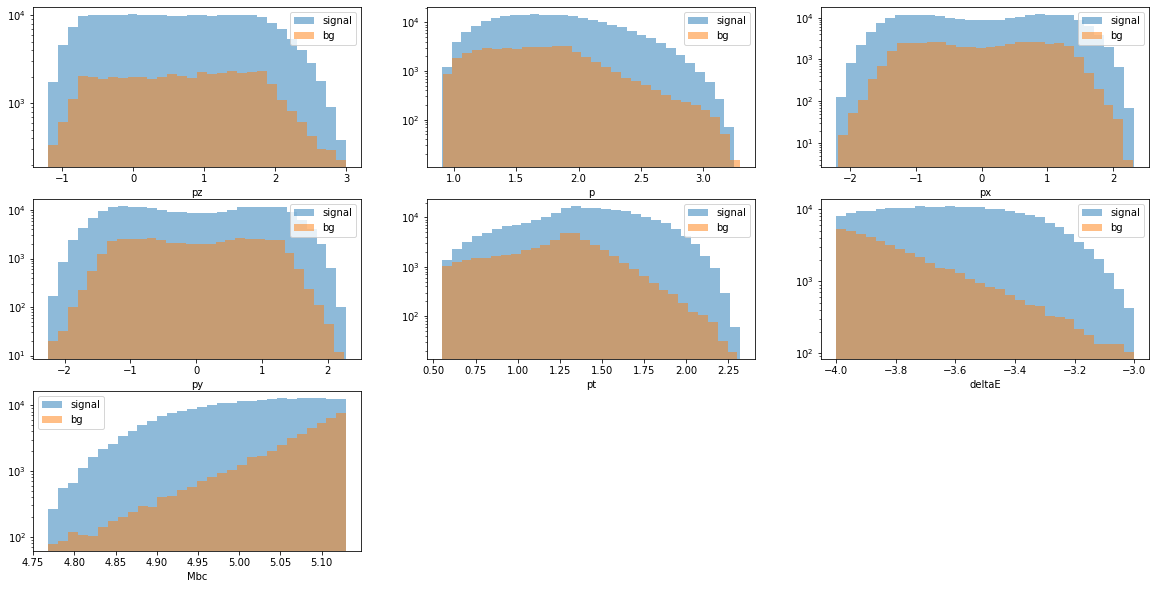

In [61]:
e_signal = e.loc[(np.abs(e['genMotherPDG'])==511) & (np.abs(e['pz'])<3) & (np.abs(e['p'])<4) & (np.abs(e['px'])<4) & (np.abs(e['py'])<4) & (np.abs(e['pt'])<4) & (e['deltaE']<-3) & (e['Mbc']<5.13) & (e['pt']>0.55) & (e['pz'] > -1.2)]
e_bg = e.loc[(np.abs(e['genMotherPDG'])!=511) & (np.abs(e['pz'])<3) & (np.abs(e['p'])<4) & (np.abs(e['px'])<4) & (np.abs(e['py'])<4) & (np.abs(e['pt'])<4) & (e['deltaE']<-3)& (e['Mbc']<5.13) & (e['pt']>0.55) & (e['pz'] > -1.2)]
plot_cuts(e_signal, e_bg)

In [62]:
print(len(e_precut_sig), len(e_signal), len(e_precut_bg), len(e_bg))

370542 235616 2150366 46936


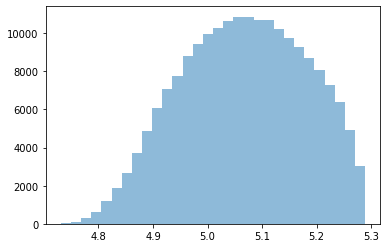